In [37]:
# import necessary packages
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# updates methods and classes from external files in the notebook 
%load_ext autoreload
%autoreload 2

First step is to import dataset. Here we use FasionMNIST dataset: 70000 of 28*28 8-bit images of clothing (https://www.kaggle.com/datasets/zalando-research/fashionmnist). 60K of images belong to train part and 10K - test samples. Each training and test example is assigned to one of 10 labels.

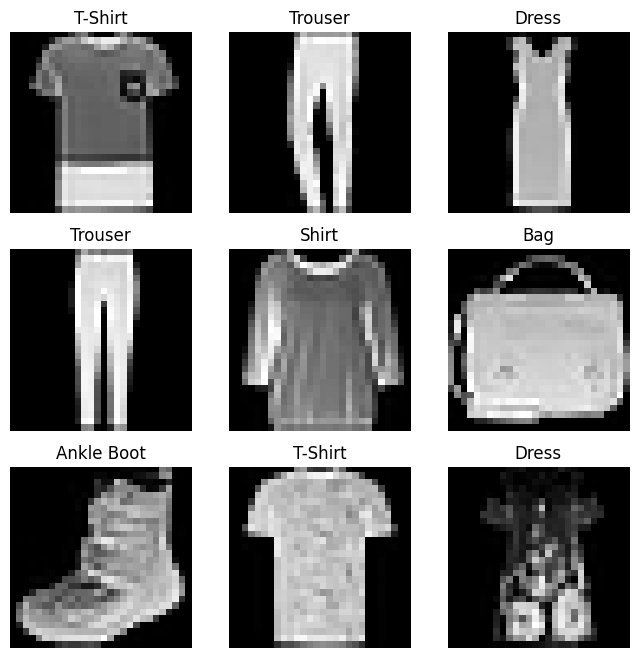

In [32]:
# import FashionMNIST dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()  # converts PIL.image to torch.Tensor
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()  # converts PIL.image to torch.Tensor
)

# labels for the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  # converts (A×1×B×C×1×D) then the input.squeeze() will be of shape (A×B×C×D)
plt.show()

DataLoader wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [35]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [36]:
# Choouse device to make calculations
device = (
    "cuda"  # for NVidia GPU cards
    if torch.cuda.is_available()
    else "mps"  # for mac with M chips
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [41]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [44]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")



Epoch 1
-------------------------------
loss: 2.314751  [   64/60000]
loss: 2.297275  [ 6464/60000]
loss: 2.289875  [12864/60000]
loss: 2.278718  [19264/60000]
loss: 2.254425  [25664/60000]
loss: 2.241568  [32064/60000]
loss: 2.236841  [38464/60000]
loss: 2.212926  [44864/60000]
loss: 2.206116  [51264/60000]
loss: 2.167381  [57664/60000]
Test Error: 
 Accuracy: 52.0%, Avg loss: 2.173988 

Epoch 2
-------------------------------
loss: 2.186361  [   64/60000]
loss: 2.176196  [ 6464/60000]
loss: 2.130611  [12864/60000]
loss: 2.139501  [19264/60000]
loss: 2.092494  [25664/60000]
loss: 2.044138  [32064/60000]
loss: 2.062066  [38464/60000]
loss: 1.994990  [44864/60000]
loss: 1.991080  [51264/60000]
loss: 1.914730  [57664/60000]
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.926848 

Epoch 3
-------------------------------
loss: 1.962285  [   64/60000]
loss: 1.936009  [ 6464/60000]
loss: 1.831893  [12864/60000]
loss: 1.858946  [19264/60000]
loss: 1.756426  [25664/60000]
loss: 1.710176  [32064/600

In [45]:
# save model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [46]:
# load model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [79]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
number_of_element = int(np.random.random()*100)
print(number_of_element)
x, y = test_data[number_of_element][0], test_data[number_of_element][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

54
Predicted: "Coat", Actual: "Pullover"


In [80]:
import ebsdpy

In [87]:
from ebsdpy import ReadWriteUp


ImportError: cannot import name 'ReadWriteUP' from 'ebsdpy' (/Users/nikolai/Library/CloudStorage/OneDrive-AMOLF/Desktop/Research/ML_community_AMOLF/venv/lib/python3.10/site-packages/ebsdpy/__init__.py)